In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style
hdr_plot_style()
from torch.utils.tensorboard import SummaryWriter

In [2]:
def save_model(model,path):
    """ 
    Inputs : 
    path : str
        Path and name of the model you want to save
    """
    choice = input("Do you want to save your model ?")
    if choice == "Yes":
        torch.save(model.state_dict(), path)
    print(f"Model save as {path}")

import os
def load_model(var_name,path_name):
    """ 
    Inputs : 
    var_name : str
        Name under witch you want to load the model

    path_name : str
        Name of the file you want to load

    Return :
    var_name : model 
    """
    if os.path.isfile(path_name):
        var_name.load_state_dict(torch.load(path_name))
    else :
        print("File not found")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
Définition de l'auto encodeur que nous allons utiliser

In [4]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

--- 
Définition du VAE qui va utiliser cet auto encodeur

In [5]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        
        mu, sigma = z_params

        var = sigma * sigma
        log_var = torch.log(var)

        z = torch.rand_like(mu) * sigma + mu
        kl_div = torch.sum(mu * mu + var - log_var - 1)

        return z, kl_div

In [6]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


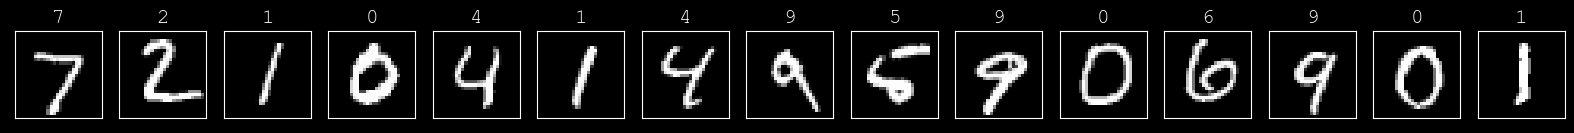

In [7]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 15
classes_names = ['0','1', '2', '3', '4', '5', '6','7', '8', '9']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [8]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)


In [9]:

def construct_encoder_decoder_complex(nin=1, n_latent = 16, n_hidden = 64, n_params = 0, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Conv2d(nin, n_hidden, 4, 2, padding=1), nn.ReLU(),
          nn.Conv2d(n_hidden, 128, 4, 2, padding=1), nn.ReLU(),
          nn.Flatten(),
          nn.Linear(7*7*2*n_hidden, 1024),nn.ReLU(),
          nn.Linear(1024, n_latent)
        )

    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent,1024), nn.ReLU(),
          nn.Linear(1024, 7*7*2*n_hidden), nn.ReLU(),
          Reshape((2*n_hidden,7,7,)),
          nn.ConvTranspose2d(2*n_hidden, n_hidden, 4, 2, padding=1), nn.ReLU(),
          nn.ConvTranspose2d(n_hidden, nin, 4, 2, padding=1), nn.Sigmoid()
        )
    return encoder, decoder

In [10]:
def compute_kernel(x, y):
    x=x.to(device)
    y=y.to(device)    
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x=x.to(device)
    y=y.to(device)
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [11]:
class InfoVAEMMD(VAE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(InfoVAEMMD, self).__init__(encoder, decoder, encoding_dims, latent_dims)
    
    def encode(self, x):
        z = self.encoder(x)
        return z

    def forward(self, x):
        # Encode the inputs
        z = self.encode(x).to(device)
        x = x.to(device)
        # Obtain latent samples and latent loss
        z_params, mmd = self.latent(x, z)

        # Decode the samples
        x_tilde = self.decode(z_params)
        return x_tilde.reshape(-1, 1, 28, 28), mmd    
    
    def latent(self, x, z_params):
        true_samples = torch.randn(len(x),n_latent)
        mmd = compute_mmd(true_samples, z_params)
        return z_params, mmd

In [12]:
# Size of latent space
n_latent = 16
# Number of hidden units
n_hidden = 64
# Rely on Bernoulli or multinomial
num_classes = 1
# Number of input channel
nin = 1



# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder_complex(nin=nin, n_latent=n_latent,n_hidden=n_hidden,n_classes= num_classes)
encoder = encoder.to(device)
decoder = decoder.to(device)
# Create VAE or (InfoVAEMMD - WAE) model
model_flow_p = InfoVAEMMD(encoder, decoder, n_hidden, n_latent).to(device)

# Create optimizer algorithm
optimizer_flow_p = torch.optim.Adam(model_flow_p.parameters(), lr=1e-4)
recons_criterion = torch.nn.BCELoss(reduction = 'sum')


In [13]:
def compute_loss_flow(model, x):
    model = model.to(device)
    x=x.to(device)
    # regularization donnée ici: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    l = 500
    
    y_pred, mmd = model(x)
    recons_loss = recons_criterion(y_pred, x)
    
    full_loss = recons_loss + mmd * l
    return full_loss

In [14]:
checkpoint = 'MNIST_CONV_MMD'
writer = SummaryWriter('runs/' + checkpoint)

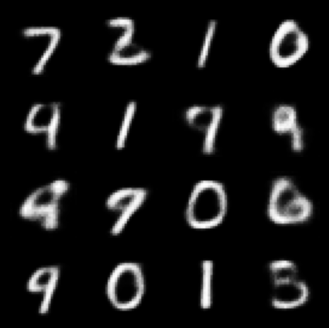

Epoch: 1, Test set MMD: 14229.0146484375


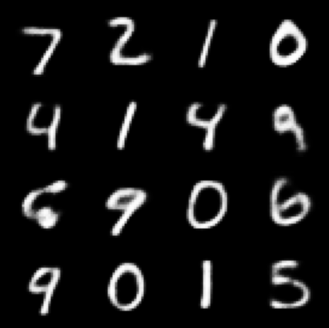

Epoch: 2, Test set MMD: 10471.9052734375


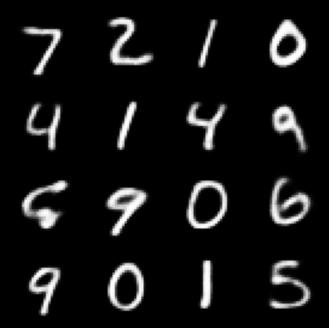

Epoch: 3, Test set MMD: 9647.568359375


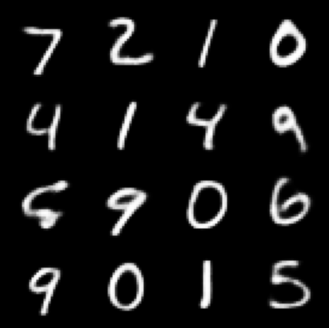

Epoch: 4, Test set MMD: 9250.435546875


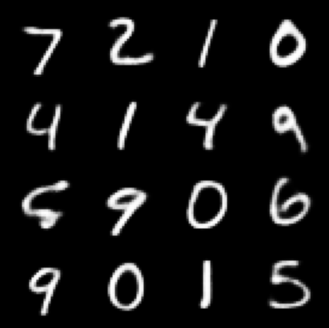

Epoch: 5, Test set MMD: 8998.8466796875


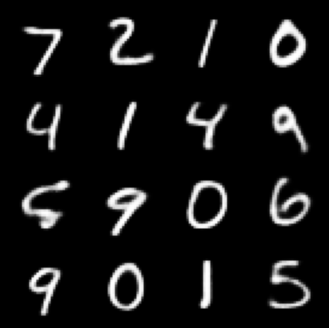

Epoch: 6, Test set MMD: 8802.8759765625


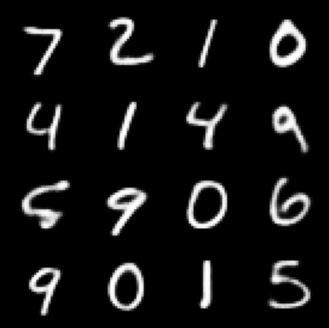

Epoch: 7, Test set MMD: 8665.650390625


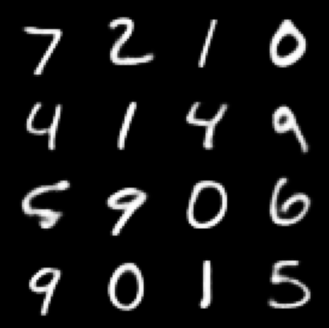

Epoch: 8, Test set MMD: 8552.7255859375


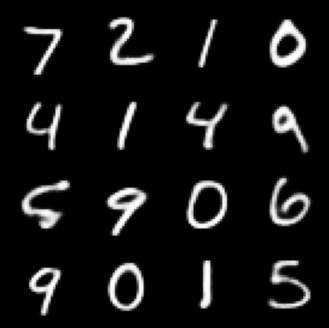

Epoch: 9, Test set MMD: 8456.125


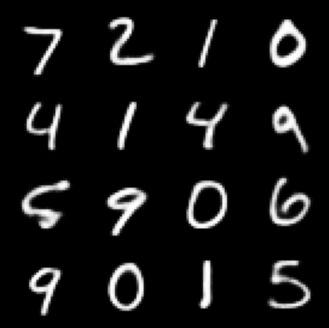

Epoch: 10, Test set MMD: 8373.12109375


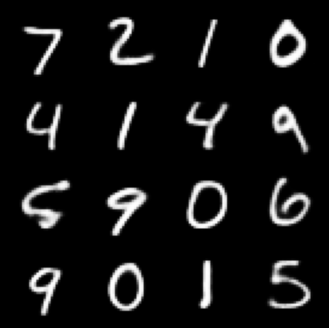

Epoch: 11, Test set MMD: 8307.5830078125


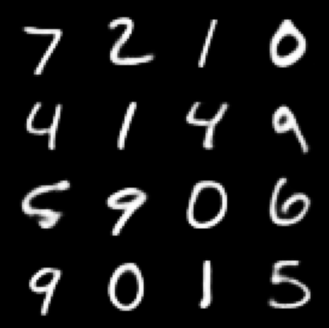

Epoch: 12, Test set MMD: 8247.9345703125


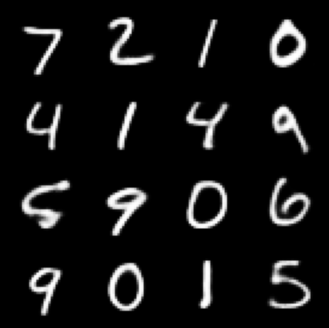

Epoch: 13, Test set MMD: 8200.4345703125


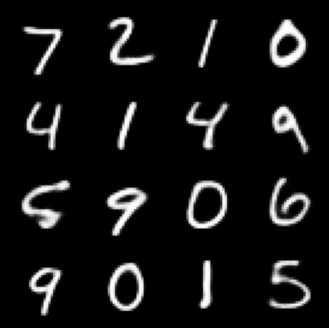

Epoch: 14, Test set MMD: 8145.65576171875


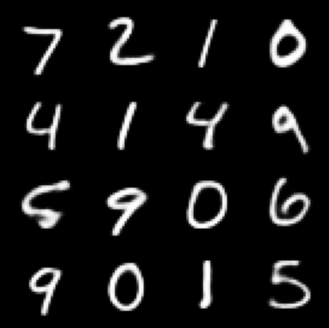

Epoch: 15, Test set MMD: 8100.548828125


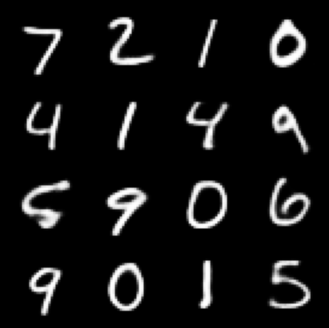

Epoch: 16, Test set MMD: 8061.04296875


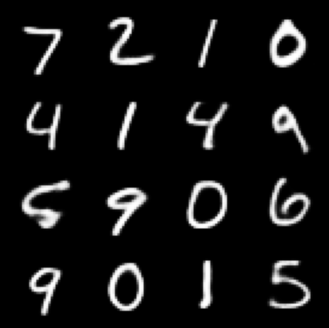

Epoch: 17, Test set MMD: 8022.017578125


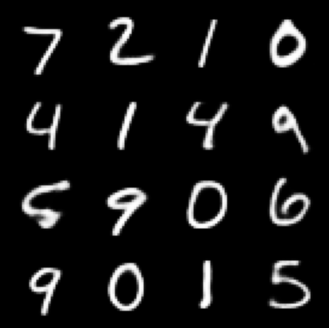

Epoch: 18, Test set MMD: 7994.1787109375


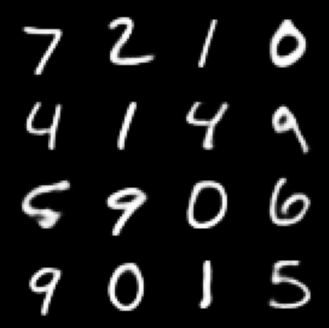

Epoch: 19, Test set MMD: 7961.3291015625


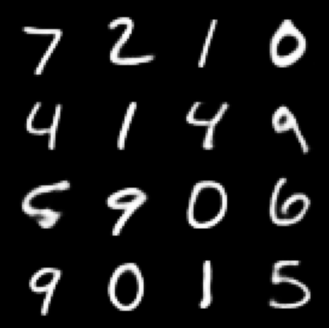

Epoch: 20, Test set MMD: 7929.03564453125


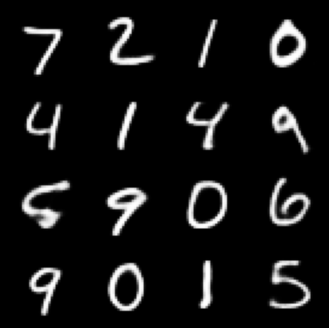

Epoch: 21, Test set MMD: 7916.37744140625


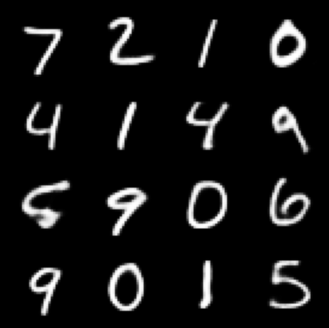

Epoch: 22, Test set MMD: 7898.76416015625


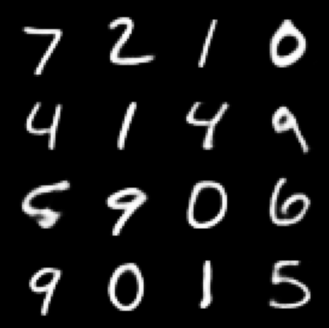

Epoch: 23, Test set MMD: 7862.00537109375


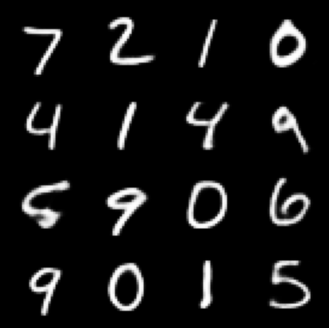

Epoch: 24, Test set MMD: 7834.0869140625


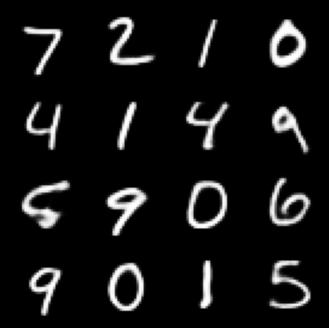

Epoch: 25, Test set MMD: 7813.71875


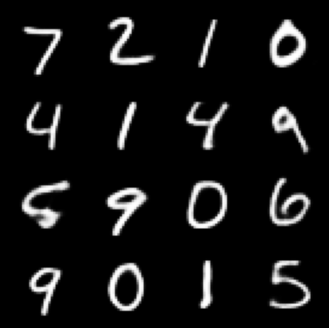

Epoch: 26, Test set MMD: 7790.11962890625


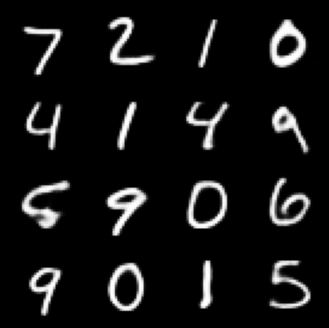

Epoch: 27, Test set MMD: 7766.11962890625


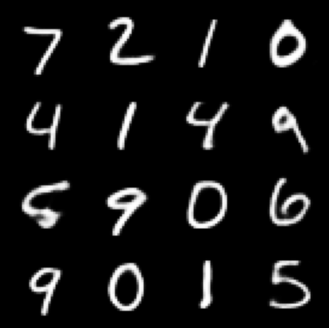

Epoch: 28, Test set MMD: 7740.52490234375


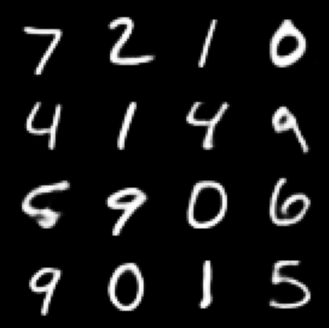

Epoch: 29, Test set MMD: 7720.98779296875


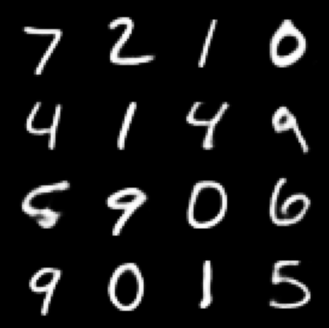

Epoch: 30, Test set MMD: 7704.08984375


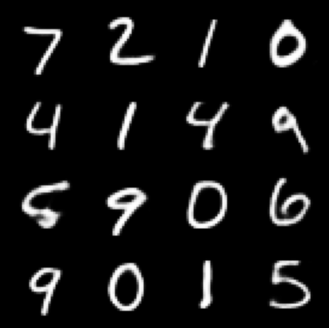

Epoch: 31, Test set MMD: 7688.72607421875


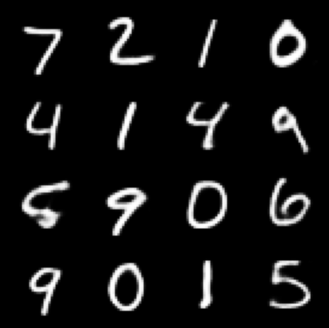

Epoch: 32, Test set MMD: 7671.9560546875


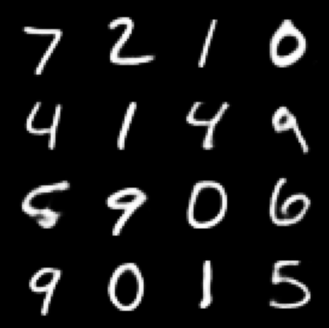

Epoch: 33, Test set MMD: 7655.013671875


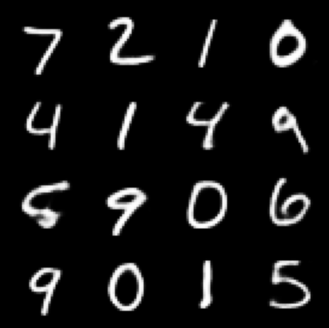

Epoch: 34, Test set MMD: 7637.349609375


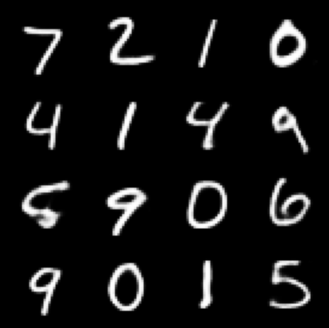

Epoch: 35, Test set MMD: 7621.859375


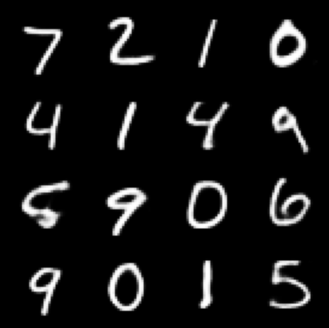

Epoch: 36, Test set MMD: 7605.39794921875


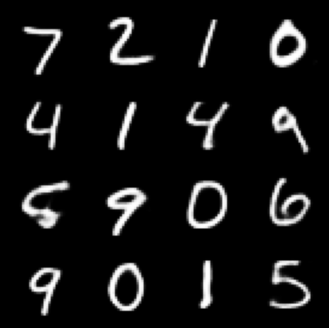

Epoch: 37, Test set MMD: 7597.142578125


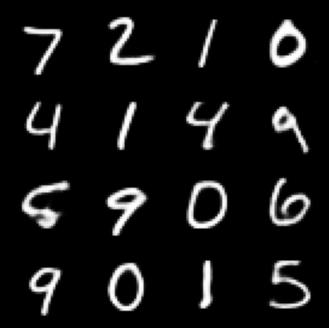

Epoch: 38, Test set MMD: 7587.84375


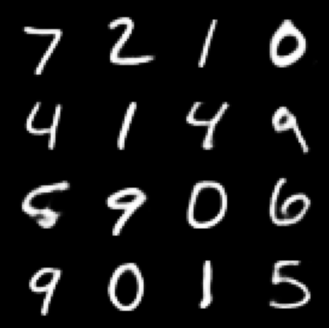

Epoch: 39, Test set MMD: 7589.986328125


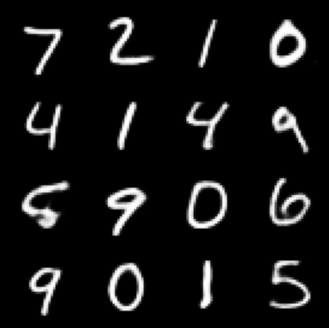

Epoch: 40, Test set MMD: 7565.23583984375


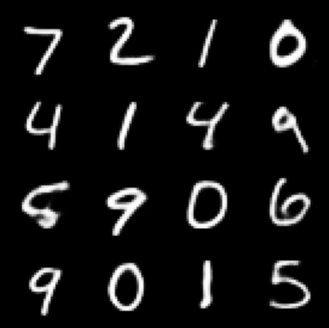

Epoch: 41, Test set MMD: 7588.3447265625


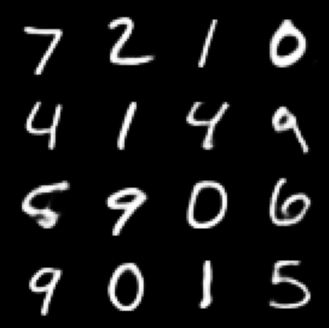

Epoch: 42, Test set MMD: 7580.7119140625


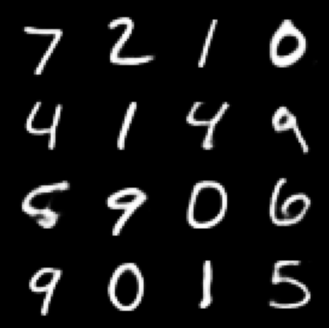

Epoch: 43, Test set MMD: 7547.41064453125


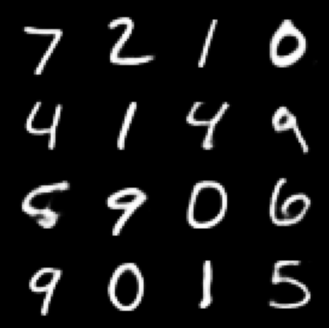

Epoch: 44, Test set MMD: 7522.01904296875


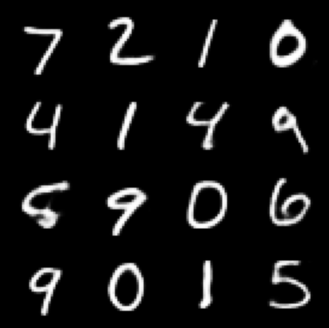

Epoch: 45, Test set MMD: 7498.96484375


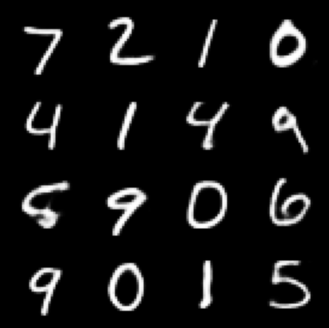

Epoch: 46, Test set MMD: 7481.9775390625


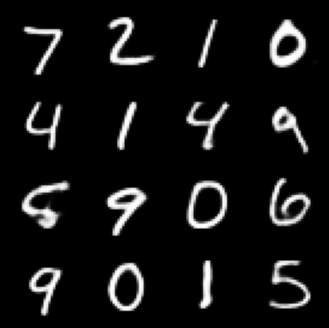

Epoch: 47, Test set MMD: 7461.84033203125


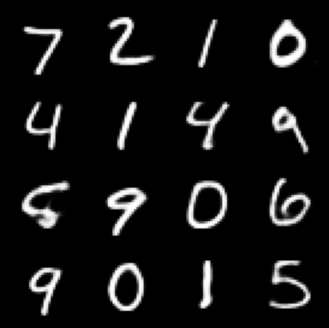

Epoch: 48, Test set MMD: 7444.818359375


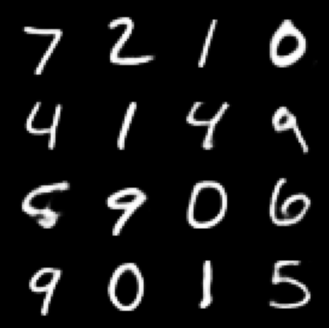

Epoch: 49, Test set MMD: 7433.40576171875


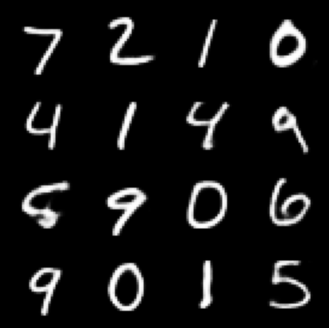

Epoch: 50, Test set MMD: 7423.47900390625


In [15]:
# Launch our optimization
epochs=50
test_sample = imgs_test[0:16, :, :, :].to(device)

for epoch in range(1, epochs + 1):

    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):

        # Pass model and data to the device (GPU or CPU)
        model_flow_p = model_flow_p.to(device)
        x = x.to(device)     

        # forward the model
        y_pred, mmd = model_flow_p(x)
    
        # compute loss
        loss_flow = compute_loss_flow(model_flow_p, x)
    
        # Before the backward pass, zero all of the network gradients
        optimizer_flow_p.zero_grad()
   
        # Backward pass: compute gradient of the loss with respect to parameters
        loss_flow.backward()
    
        # Calling the step function to update the parameters
        optimizer_flow_p.step()
    writer.add_scalar("Loss/Loss_Flow", loss_flow.cpu().detach().numpy(),epoch)    

    predictions, _ = model_flow_p(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach().cpu(), cmap='gray')
        plt.axis('off')
    plt.show()
    writer.add_figure("Image/Test_Visu", fig,epoch) 
    writer.flush()

    print('Epoch: {}, Test set MMD: {}'.format(epoch, loss_flow))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 16x1024)

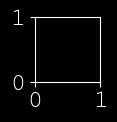

In [17]:
# Problème pour rééchantilloner comme pas come un espace latent claqqieu
nb_image = 10
x = np.linspace(-3, 3, nb_image)
y = np.linspace(-3, 3, nb_image)
fig = plt.figure(figsize=(10, nb_image))
for i in range(nb_image):
    for j in range(nb_image):
        plt.subplot(nb_image, nb_image, (i * nb_image) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model_flow_p.decode(final_tensor.to(device)).cpu().detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

In [ ]:
torch.save(model_flow_p.state_dict(), './data/MNIST_CONV_mmd.pt')

In [18]:
#load_model("./data/MNIST_mmd.pt")
path = './data/MNIST_CONV_mmd.pth'
save_model(model_flow_p,path)

Model save as ./data/MNIST_CONV_mmd.pth
